# **LoRA Fine-Tuning with Distributed Data Parallel (DDP) Notebook**

### **LoRA Fine-Tuning with Distributed Data Parallel Readme:**

For more information on LoRA Fine-Tuning with Distributed Data Parallel, refer to the [LoRA Fine-Tuning with Distributed Data Parallel Readme](../lora_finetuning_with_ddp_readme.md).

### **About This Notebook:**

This notebook demonstrates `LoRA Fine-Tuning with Distributed Data Parallel`. Compared to the [LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning.ipynb), the following modifications have been made:

1. A custom device map was created for multi-GPU training in Distributed Data Parallel. During training, multiple ranks (processes) are initiated in parallel, with each rank allocating its model layers to the GPU it is bound to.

2. An optional custom callback function is defined to validate data parallelism in DDP. At the first training step, this callback reports VRAM usage and prints details of the mini-batch dispatched to the current rank, including the mini-batch size and the first data in the mini-batch. These details confirm that each rank (GPU) processes a distinct batch of data from the dataset, ensuring proper data parallelism.

3. LoRA fine-tuning-related pre-training and training steps are encapsulated in a workflow function. The following modifications were added to support DDP:  
   3.1. Initialize an accelerator to provide the current rank (process) ID, which helps bind the current rank to its corresponding GPU.  
   3.2. Override the `print()` function to prepend a prefix string. This ensures individual rank outputs can be identified even when all ranks' outputs are mixed in the terminal, facilitating debugging.  
   3.3. Use only the main rank (rank 0, GPU 0) for specific tasks such as account logins, file writing, and model inference to avoid redundant logins and file conflicts in multi-process environments.  
   3.4. Apply additional trainer configurations for DDP, including enabling non-reentrant gradient checkpointing for faster backward passes and disabling checks for unused parameters to reduce computational overhead.  
   3.5. Unlike standard multi-GPU training, this notebook does not apply learning rate scaling. Typically, the learning rate increases proportionally with the batch size. In this notebook, the effective batch size during training scales up linearly with the GPU count allocated for training. However, in LoRA fine-tuning, less aggressive updates are required as fewer parameters are modified. Consequently, no scaling or minimal scaling is sufficient, as LoRA adapters generally perform well with smaller learning rates.

4. Since the training workflow function is saved in an external Python file, removing the Python cache folder (`__pycache__`) and restarting the kernel after modifying the workflow content ensures that the notebook does not pick up old cached content.

5. Two approaches are demonstrated to execute the training workflow function: using `notebook_launcher` or `accelerate launch`.

### **Supporting Python Files:**

- `my_login.py`: Contains reusable login functions (e.g., for Hugging Face and Weights & Biases). Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils.py`: Contains general-purpose utility functions for fine-tuning. Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils_lora_finetuning_with_ddp.py`: Contains utility functions specific to LoRA fine-tuning with Distributed Data Parallel. Created within this notebook.
- `my_workflow_lora_finetuning_with_ddp.py`: Contains a workflow function that encapsulates LoRA fine-tuning-related pre-training and training steps, along with the modifications required for DDP. Created within this notebook.

### **Experiment Settings:**

This experiment is conducted within a pod (container instance) provided by [RunPod](https://runpod.io). The specific configurations are as follows:

- `Template (Docker Container Image)`: runpod/pytorch:2.4.0-py3.11-cuda12.4.1-devel-ubuntu22.04
- `Volume Disk`: 150GB (model checkpoints storage)
- `GPU Setup`: 2 Nvidia A6000 GPUs (48GB VRAM)

---
# **Step 1: Preparation**

## 1.1 Install Necessary Python Packages

In [1]:
!python -m pip install -q -U pip            # [optional] upgrade pip
!pip install huggingface_hub==0.25.1 -q -U  # hf lib to login to huggingface and download dataset, model
!pip install hf_transfer==0.1.8 -q -U       # hf lib to speed up huggingface data transfer 
!pip install transformers==4.46.0 -q -U     # hf lib to load model and processor(tokenizer)
!pip install accelerate==0.34.2 -q -U       # hf lib to support 'device_map', restart kernel required after installation
!pip install flash-attn==2.6.3 -q -U        # to reduce vram usage for llama model, restart kernel recommended after installation
!pip install datasets==3.0.0 -q -U          # hf lib to load dataset
!pip install peft==0.13.0 -q -U             # hf lib to support lora fine-tuning
!pip install matplotlib==3.9.2 -q -U        # to plot similarity score comparison graphs
!pip install tensorboard==2.18.0 -q -U      # to support logging with tensorboard
!pip install wandb==0.18.1 -q -U            # to support logging with weights and biases (wandb)
!pip install ipython==8.28.0 -q -U          # to enable %% magic functions in a jupyter notebook


Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet


## 1.2 Restart Kernel to Activate Installed Packages

---
# **Step 2: Pre-training & Training**

## 2.1 Define Utility Functions for LoRA Fine-Tuning with Distributed Data Parallel

In [1]:
%%writefile my_utils_lora_finetuning_with_ddp.py
#--------------- Functions in LoRA Fine-Tuning with Distributed Data Parallel ---------------
# 1) Override the built-in print() function to prepend a prefix string to all printed messages.
import builtins
def add_prefix_to_print_function(prefix_string):
    original_print = builtins.print                               # Save a reference to the original print function
    def custom_print(*args, **kwargs):                            # Define a custom print function
        args = (f"{prefix_string} {' '.join(map(str, args))}",)   # Prepend the prefix string to the original print message
        original_print(*args, **kwargs)                           # Call the original print function with the modified arguments
    builtins.print = custom_print                                 # Override the built-in print function

# 2) Create Custom Device Map (Multi-GPU) for Distributed Data Parallel
def create_device_map_ddp_multi_gpu(accelerator):
    rank = accelerator.process_index                              # Get the current rank (process) ID from the accelerator
    device_map = {'': rank}                                       # Allocate all model layers to the GPU matching the current rank ID
    return device_map

# 3) Create Custom Device Map (Single-GPU)
def create_device_map_ddp_single_gpu0():   
    device_map = {'': 0}                                          # Allocate all model layers to the single GPU0
    return device_map

# 4) Define a custom callback function to report VRAM usage, print the mini-batch size, and print the first data in the mini-batch.
# Note: At every training step, each GPU receives an individual mini-batch from the dataloader in DDP. Printing the mini-batch size and the first data in the mini-batch at training step 1 helps validate that each GPU processes a different batch from the dataset, ensuring proper data parallelism.
import torch
from transformers import TrainerCallback
class CustomCallbackDDP(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        # If the current process is using a GPU and this is the first training step:
        if torch.cuda.is_available() and state.global_step == 1:
            # Report VRAM usage
            gpu_id = torch.cuda.current_device()
            gpu_memory = torch.cuda.memory_allocated(gpu_id) / (1024 ** 3)
            gpu_max_memory = torch.cuda.max_memory_allocated(gpu_id) / (1024 ** 3)
            total_memory = torch.cuda.get_device_properties(gpu_id).total_memory / (1024 ** 3)
            print(f'Step {state.global_step}: Current VRAM usage: {gpu_memory:.2f} GB, Peak VRAM usage: {gpu_max_memory:.2f} GB, Total GPU VRAM: {total_memory:.2f} GB')

            # Print mini-batch size and the first data in the mini-batch
            train_dataloader = kwargs.get('train_dataloader')     # Retrieve the dataloader from kwargs
            if train_dataloader is not None:
                for batch in train_dataloader:
                    input_data = batch.get('input_ids', None)
                    if input_data is not None:
                        batch_size = input_data.size(0)           # Get the size of the mini-batch
                        first_input_data = input_data[0].tolist() # Convert the first data in the mini-batch to a list
                        print(f'Step {state.global_step}: Mini-batch size: {batch_size}')
                        print(f'Step {state.global_step}: 1st data in mini-batch: {first_input_data}')
                    else:
                        print(f'Step {state.global_step}: No input data available in the mini-batch.')
                    break                                         # Stop after processing the first mini-batch to avoid iterating through the entire dataloader

Writing my_utils_lora_finetuning_with_ddp.py


## 2.2 Wrap Pre-Training and Training Steps into a Training Workflow Function

In [2]:
%%writefile my_workflow_lora_finetuning_with_ddp.py
#--------------- A Training Workflow in LoRA Fine-Tuning with Distributed Data Parallel ---------------
def training_workflow():
    import my_login
    import my_utils
    import my_utils_lora_finetuning_with_ddp

    # **Step 1: Rank (Process) Initialization**
    ## 1.1 Initialize an Accelerator at the Beginning of Each Rank (Process)
    import torch
    from accelerate import Accelerator
    accelerator = Accelerator()
    rank = accelerator.process_index                  # Get the current rank (process) ID
    torch.cuda.set_device(rank)                       # Bind the current rank (process) to the GPU with the same ID (e.g., rank 0 to GPU 0, rank 1 to GPU 1, etc.)

    ## 1.2 Override print() to Prepend a Prefix String ('[RANK{current rank ID}:GPU{current GPU ID}]') to All Printed Messages
    gpu_id = torch.cuda.current_device()
    prefix_string = f'[RANK{rank}:GPU{gpu_id}]'
    my_utils_lora_finetuning_with_ddp.add_prefix_to_print_function(prefix_string)
    print(f'==> Process started...')

    # **Step 2: Pre-training**
    ## 2.1 Log in to Required Accounts (e.g., Hugging Face, Weights & Biases)
    if accelerator.is_main_process:                                        # Only use rank 0 to log in to avoid multiple logins
        # Log in to the Hugging Face account to access the Idefics2 model and the dataset
        my_login.login_hf()
        # Log in to the Weights & Biases account to enable tracking of training progress
        my_login.login_wandb()
    accelerator.wait_for_everyone()                                        # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.2 Load the Processor (Tokenizer) and the Base Model
    # Load processor
    processor = my_utils.load_processor()
    # Load model
    base_model = my_utils.load_model(device_map=my_utils_lora_finetuning_with_ddp.create_device_map_ddp_multi_gpu(accelerator))  # Use a custom device map: The model processed in the current rank (process) should be allocated to the GPU bound to this rank. Thus, all model layers are allocated to the GPU matching the current rank ID.
    if accelerator.is_main_process:                                        # Only use rank 0 to write files to avoid multi-process file writing
        my_utils.print_processor_info_to_file(processor, './results/model_info/original_processor_info.txt')
        my_utils.print_model_info_to_file(base_model, './results/model_info/base_model_info.txt')
        my_utils.print_model_parameters_to_file(base_model, './results/model_info/base_model_parameters.txt')
    accelerator.wait_for_everyone()                                        # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.3 Load the Dataset
    # Load the Hugging Face dataset
    dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

    ## 2.4 Perform Inference with the Base Model to Establish a Baseline
    if accelerator.is_main_process:                                        # Only use rank 0 to run inference to avoid multi-process file writing
        # Perform batch inference on the test set and save results to a CSV file
        my_utils.batch_inference_model(base_model, processor, dataset['test'], './results/inference_results/inference_results_before_finetuning.csv', 14)
        # Plot similarity scores from the inference CSV file, using thumbnails, and save the plot image locally
        my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv')],
                                        thumbnail_dir='./results/inference_results/thumbnail',
                                        plot_file_name='./results/inference_results/similarity_scores_before_finetuning.jpg'
        )
    accelerator.wait_for_everyone()                                        # Synchronize across all ranks to ensure rank 0 finishes

    # **Step 3: Training**
    ## 3.1 Add a Custom Padding Token
    # Set up pad token (<pad>) in the processor
    my_utils.setup_pad_token_in_processor(processor)
    # Set up pad token (<pad>) in the base model
    my_utils.setup_pad_token_in_model(base_model, processor)

    ## 3.2 Create a LoRA Adapter
    # Create LoRA adapter with rank=8 and lora_alpha=64
    lora_model = my_utils.create_lora_adapter(base_model, 8, 64)
    if accelerator.is_main_process:                                         # Only use rank 0 to write files to avoid multi-process file writing
        my_utils.print_model_info_to_file(lora_model, './results/model_info/lora_model_info.txt')
        my_utils.print_model_parameters_to_file(lora_model, './results/model_info/lora_model_parameters.txt')
    accelerator.wait_for_everyone()                                         # Synchronize across all ranks to ensure rank 0 finishes

    ## 3.3 Set Up the Trainer
    custom_callback = my_utils_lora_finetuning_with_ddp.CustomCallbackDDP() # Optional: Reports VRAM usage and validates data parallelism by printing mini-batch details during the first training step.
    trainer = my_utils.setup_trainer(lora_model, processor, dataset, my_utils.collate_fn, epoch_num=3, batch_size=14, callbacks=[custom_callback])
    # Additional trainer setup in LoRA Fine-Tuning with DDP
    trainer.args.gradient_checkpointing_kwargs = {'use_reentrant': False}   # In DDP, use a non-reentrant backward pass to skip extra autograd graph traversals, making the backward pass faster.
    trainer.args.ddp_find_unused_parameters = False                         # Skip unnecessary checks for unused parameters to reduce overhead during backward computation

    ## 3.4 Train the Model
    my_utils.run_training(lora_model, trainer)

if __name__ == "__main__":
    training_workflow()

Writing my_workflow_lora_finetuning_with_ddp.py


## 2.3 Execute the Training Workflow Function

This notebook will initialize multiple ranks (processes) in parallel. Each rank will execute an individual training workflow on the GPU to which it is bound.

There are two approaches to execute the training workflow function: use `notebook_launcher` or use `accelerate launch`.

### **(Approach 1) Use `notebook_launcher` to Execute the Training Workflow Function:**

- Notebook Launcher Tutorial: [HF: Launching distributed training from Jupyter Notebooks](https://huggingface.co/docs/accelerate/main/en/basic_tutorials/notebook#using-the-notebooklauncher)
- Notebook Launcher Reference: [HF: Launchers](https://huggingface.co/docs/accelerate/main/en/package_reference/launchers#accelerate.notebook_launcher)


In [ ]:
from accelerate import notebook_launcher
import my_workflow_lora_finetuning_with_ddp

# Execute the training workflow function
notebook_launcher(my_workflow_lora_finetuning_with_ddp.training_workflow, num_processes=2)  # Allocate 2 ranks (processes, GPUs) to execute the training workflow in parallel

### **(Approach 2) Use `accelerate launch` to Execute the Training Workflow Function:**

- Accelerate Launch Reference: [HF: accelerate launch](https://huggingface.co/docs/accelerate/main/en/package_reference/cli#accelerate-launch)


In [3]:
# Execute the training workflow function
!accelerate launch --num_processes=2 my_workflow_lora_finetuning_with_ddp.py  # Allocate 2 ranks (processes, GPUs) to execute the training workflow in parallel

The following values were not passed to `accelerate launch` and had defaults used instead:
		More than one GPU was found, enabling multi-GPU training.
		If this was unintended please pass in `--num_processes=1`.
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
[RANK1:GPU1] ==> Process started...
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
[RANK0:GPU0] ==> Process started...
[RANK0:GPU0] ==> Logging in to Hugging Face...
[RANK0:GPU0] The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential a

---
# **Step 3: Post-Training**

## 3.1 Restart Kernel for a Clean Environment

## 3.2 Load the Fine-Tuned Model from a Checkpoint  

After training, we load the fine-tuned model using the checkpoint with the minimum loss. This fine-tuned model will be used for further inference to assess improvements in model performance.

For post-training inference, a single GPU is sufficient, and there is no need to allocate multiple GPUs as was done during the training stage. Therefore, the model is loaded onto `GPU0`.


In [1]:
# Load functions
import my_login
import my_utils
import my_utils_lora_finetuning_with_ddp

# Log in to the Hugging Face and Weights & Biases accounts
my_login.login_hf()
my_login.login_wandb()

# Load processor and base model
processor = my_utils.load_processor()
base_model = my_utils.load_model(device_map=my_utils_lora_finetuning_with_ddp.create_device_map_ddp_single_gpu0())

# Set up pad token (<pad>) in the processor and in the base model
my_utils.setup_pad_token_in_processor(processor)
my_utils.setup_pad_token_in_model(base_model, processor)

# Load LoRA adapter from a checkpoint with the minimum loss
lora_model = my_utils.load_lora_adapter_from_checkpoint(base_model, './results/training_checkpoints/checkpoint-60')


==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


==> Loading processor...
==> Loading model...


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Setting up pad token (<pad>) in processor...
==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
==> Adding new pad token: <pad>
==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
==> Setting up pad token (<pad>) in model...
==> Configuring pad token in model.config and model.model.text_model for input sequence padding...
==> Configuring pad token in model.generation_config for output sequence padding...
==> Checking if resizing of model embeddings is needed...


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Resized model embeddings from 32003 to 32004.
==> Loading LoRA adapter from checkpoint...


## 3.3 Perform Inference with the Fine-Tuned Model

==> Loading hf dataset...
==> Performing batch inference and saving results to ./results/inference_results/inference_results_after_finetuning.csv ...
==> [Batch: 1/6] Data in batch: 14
==> [Batch: 1/6][Data: 1/14] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


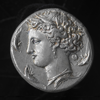

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, an exquisite coin from the late 5th century BCE, known for its remarkable artistry and high relief, attributed to designers like Kimon and Euinatos. The coin's intricate details, including the facial features and the intricate hair style, have captivated collectors for centuries. An intriguing historical note is the connection to Theodore Roosevelt, the American president known for his reformative policies. He was discontent with the mundane design of contemporary American coins and sought to elevate the artistic standards of U.S. currency. His inspiration came from this very coin, leading him to collaborate with sculptor Augustus Saint-Gaudens on the creation of t

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


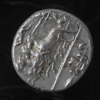

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, an exquisite coin from the late 5th century BCE, renowned for its intricate artistry and high relief, attributed to designers like Kimon and Euinatos. The coin's captivating design, which includes a detailed horse head, has fascinated collectors for centuries. An intriguing historical note is the connection to Theodore Roosevelt, the American president known for his reformative policies. He was discontent with the mundane nature of contemporary American coins and compared them unfavorably to classical masterpieces like the dekadrachm. His desire for more artistic coins led him to collaborate with sculptor Augustus Saint-Gaudens, resulting in the

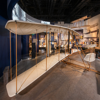

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the historic 1903 Wright Flyer, the first successful powered aircraft to carry a pilot. Designed and built by Wilbur and Orville Wright, the Flyer is powered by a 12-horsepower engine and utilizes a unique sprocket-and-chain transmission system to drive two pusher propellers. It made its inaugural flight on December 17, 1903, at Kitty Hawk, North Carolina, with Orville at the controls for a remarkable 12-second journey covering 36 meters (120 feet). The Wright brothers' groundbreaking work in aeronautical engineering, including the development of wind tunnels and the use of wing warping for control, laid the foundation for modern aviation. This significant artifact is part of the National 

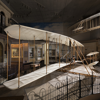

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wright Flyer, the first successful powered aircraft to carry a pilot, which made its historic flight on December 17, 1903, at Kitty Hawk, North Carolina. Designed and built by Wilbur and Orville Wright, the Flyer is powered by a 12-horsepower engine and utilizes a unique sprocket-and-chain transmission system to drive two pusher propellers. Its innovative design includes skids for landing and a non-wheeled configuration that allows for easier takeoff and landing. The Wright brothers' groundbreaking research over four years led to the development of key aeronautical engineering principles, including wind tunnel testing and the use of wing warping for control. This la

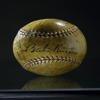

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an autographed baseball from the legendary Babe Ruth, dating back to around 1927, housed at the Smithsonian's National Museum of American History. Ruth, a Hall of Famer, is celebrated for his remarkable career as a baseball player, particularly with the New York Yankees. He is known for his impressive batting skills, including a record 60 home runs in a single season. The baseball itself is a cork center, wool layers, and a horsehide cover, measuring approximately 3 inches in diameter. Although it is currently not on display, it is part of the museum's extensive collection, which includes over 10,000 artifacts related to the history of baseball. This item was generously donated by the Elli

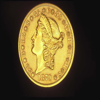

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold coin from the United States Mint in Philadelphia, minted in 1879 and bearing the reference Coinage Act of 1878. The coin's obverse displays a Liberty head facing left, with the date placed just below and specifications about weight and fineness surrounding it. On the reverse side, an eagle is depicted, but it carries the Latin motto DEO EST GLORIA instead of the traditional IN GOD WE TRUST. This design was part of an initiative to enhance the international appeal of American coins and was only produced in limited quantities. The coin in this exhibit is one of the earliest examples of this design and is currently not on view. It measures 34.3 mm and is made from a combinat

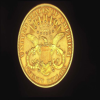

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold coin minted by the United States Mint in Philadelphia, showcasing a unique design that includes an eagle, a shield, and the Latin motto DEO EST GLORIA, all set against a dark background. The obverse displays a left-facing Liberty head, with the date placed just below. This coin is part of a larger series aimed at enhancing the competitiveness of American coinage in international markets, akin to the four-dollar gold Stella coin. Only nine of these gold coins are known to exist, including this one, which was last sold in 1994. Currently, it is not on display.
==> Ground truth answer: This exhibit highlights a significant gold coin minted by the United S

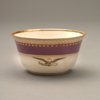

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Abraham Lincoln's coffee cup, an artifact with a fascinating history. On the evening of April 14, 1865, just before attending Ford's Theatre for the last time, President Lincoln inadvertently left this cup on a windowsill. A White House servant preserved it as a relic, and it was later given to Robert Todd Lincoln, the eldest son of Lincoln, by Capt. D.W. Taylor in 1887. The cup is made of ceramic and features a striking design in purple with white and gold trim, measuring approximately 3 1/4 inches in height. It was donated to the Smithsonian's National Museum of American History by Lincoln Isham, Lincoln's great-grandson, in 1958. This cup serves as a poignant reminder of Lincoln's legac

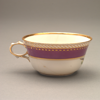

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Abraham Lincoln's coffee cup, an artifact with a compelling story tied to a pivotal moment in American history. On the evening of April 14, 1865, just before attending Ford's Theatre for the last time, President Lincoln inadvertently left this cup on a windowsill. A White House servant preserved it as a relic, and it was later given to Robert Todd Lincoln, the president's eldest son, by Capt. D.W. Taylor in 1887. The cup is crafted from ceramic and features a striking purple color with white and gold trim, measuring approximately 3 1/4 inches in height. It was donated to the Smithsonian's National Museum of American History by Lincoln Isham, Lincoln's great-grandson, in

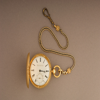

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not one to show off, this exquisite watch served as a testament to his success as a lawyer. The watch's movement, crafted in Liverpool, is renowned for its high-quality standards, and the case was made by an unidentified American manufacturer. A fascinating aspect of this watch is the hidden message engraved by watchmaker Jonathan Dillon during repairs on April 12, 1861, the day of the Confederate attack on Fort Sumter. Dillon's engraving, along with a later inscription by another watchmaker, remains a mystery, but it is clear that the watch w

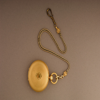

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not one to show off, this exquisite watch served as a testament to his success as a lawyer. The watch's movement, crafted in Liverpool, a renowned watchmaking city, is known for its high-quality standards, while the case was made in the United States by an unknown artisan. A fascinating aspect of this watch is its hidden message engraved by watchmaker Jonathan Dillon during repairs on April 12, 1861, the day of the Confederate attack on Fort Sumter. Dillon's engraving, along with a later inscription by another watchmaker, L. E.

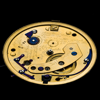

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not one to show off, this exquisite watch served as a testament to his success as a lawyer. The watch's movement, crafted in Liverpool, is renowned for its high-quality standards, and it is equipped with an 18K gold case made in the United States. A fascinating aspect of this watch is the hidden inscription left by watchmaker Jonathan Dillon, who engraved a message under the dial in 1861, marking the onset of the Civil War. Dillon's inscription was later joined by another watchmaker, L. E. Gros

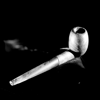

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an iconic artifact: Albert Einstein's pipe, dating back to approximately 1948. Einstein, a pivotal figure in theoretical physics and a Nobel Prize laureate, is as famous for his distinctive appearance as for his scientific achievements. While he reduced his smoking later in life for health reasons, he could not relinquish the tactile pleasure of the pipe itself. This particular pipe shows significant wear, indicating its frequent use, and was gifted to Gina Plunguian, a devoted friend of Einstein. The Smithsonian acquired this item in 1979, and it is part of a larger collection that includes over 1,000 artifacts displayed at various Smithsonian Affiliates. Currently, it is on display at th

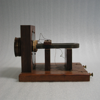

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the pivotal invention of the telephone by Alexander Graham Bell, who received the first patent for this groundbreaking device on March 7, 1876. Just three days later, Bell successfully communicated with his assistant, Thomas Watson, marking a significant milestone in communication history. The exhibit includes one of the two telephones used during a demonstration between Boston and Salem on November 26, 1876. This particular telephone is notable for its design, which includes an iron diaphragm and two electromagnets, and it is one of the few telephones in the Smithsonian's collection that is still functional. Acquired in 1923 from the American Telephone & Telegraph Co., this artifact is pa

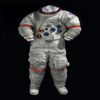

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apollo 17 spacesuit, an iconic piece of history from the final Apollo mission that landed humans on the moon in December 1972. The mission was launched on December 7, 1972, by a Saturn V rocket and included Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, who was the first geologist to walk on the moon. While Evans remained in orbit, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region and conducted three moonwalks over three days, collecting 110 kilograms of lunar samples and driving a lunar rover for 35 kilometers. They also operated the lunar surface for the last time, driving the rover into the Pacific

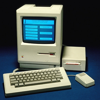

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apple "Classic" Macintosh Personal Computer, which was introduced by Apple Inc. in January 1984. The Macintosh was a revolutionary device that introduced a graphic user interface, allowing users to interact with their computers through visual icons rather than traditional command lines. This concept was inspired by work at Xerox's Palo Alto Research Center but was successfully commercialized by Apple, which famously launched the Macintosh with a memorable Super Bowl XVIII advertisement, priced at approximately $2,500. The original Macintosh was equipped with just 128K of RAM, which quickly proved inadequate, leading to the release of the Macintosh 512 KB, or "Fat Mac," in September 198

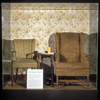

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an upholstered wing chair that was used by Archie Bunker, played by Carroll O'Connor, in the groundbreaking television series "All in the Family." The chair, which dates back to the 1940s, is upholstered in a vibrant orange-yellow woven fabric and is supported by a durable wooden frame with arms and legs. While it is currently not on display, it was donated to the Smithsonian's National Museum of American History by the show's producers, and it serves as a significant artifact of television history. "All in the Family," which aired from 1971 to 1979, was a pioneering sitcom that addressed pressing social issues of the time, making it a cultural touchstone in American television. The show's

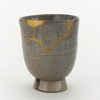

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning tea bowl from the 17th century, belonging to the White Satsuma ware category from Kagoshima prefecture, Japan. Crafted during the Edo period, the bowl showcases the artistry of kintsugi, a traditional Japanese repair technique that highlights rather than conceals damage. Unlike typical restoration methods that aim to hide imperfections, kintsugi embraces the bowl's history by incorporating gold into the repairs, transforming the object into a beautiful testament to resilience. The use of lacquer, a natural resin derived from tree sap, ensures a durable and water-resistant repair. Lacquer has been utilized in Asian ceramics for centuries, but its decorative application with gold 

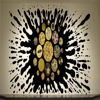

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the innovative work of Yinka Shonibare, an artist born in London in 1962. It showcases a series of 25 circular canvases, each varying in size, arranged against a large-scale ink splatter pattern applied with a template. The canvases are adorned with intricate foliate patterns painted in black and gold, using Dutch wax printed fabrics. Shonibare's artistic journey is evident as he moves from small square canvases to these dynamic roundels, which challenge conventional notions of edges and borders. The work references "black gold," a term for Africa's oil resources, and engages with the splatter techniques of Jackson Pollock, creating a playful yet thought-provoking commentary on cultural an

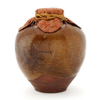

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning 17th-century tea-leaf storage jar from the Satsuma ware tradition, originating from Kagoshima prefecture, Japan, during the Edo period. The jar is characterized by its clear, dark brown glaze and the distinctive orange-red design known as "chigusa," which is often associated with the tea ceremony. It is believed that this jar was used to store tea leaves, with the chigusa design chosen to enhance its aesthetic appeal during tea gatherings. The jar's history is intriguing; it was initially donated to the Smithsonian's Freer Gallery of Art in 1913 but was later transferred to the Arthur M. Sackler Gallery in 1970, where it now resides. The exhibit is part of the "Chigusa and the A

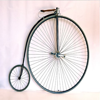

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Duryea Automobile, an iconic vehicle from 1893-94, which is recognized as one of the earliest American-made automobiles. Frank Duryea conducted a historic road test of this vehicle in Springfield, Massachusetts, on September 21, 1893, utilizing a second-hand carriage fitted with a gasoline engine. The following year, Frank and his brother Charles, along with financial backers, established the Duryea Motor Wagon Company, which became the first American firm to manufacture and sell automobiles. The vehicle is equipped with a one-cylinder, four-cycle, four-horsepower water-cooled gasoline engine, which is positioned nearly horizontally beneath the carriage. It features a gear transmission

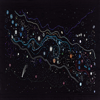

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Milky Way, Starry Night #2," a striking work by Gwich'in artist Margaret Nazon from Tsiigehtchic, Northwest Territories, Canada, created in 2021. Nazon's artistic journey began later in life, inspired by her childhood fascination with the stars. After a career as a geologist, she turned her focus to art, capturing the beauty of the night sky in her unique style. This piece, characterized by swirling galaxies, represents a departure from traditional Gwich'in beadwork and reflects Nazon's personal artistic evolution. It is part of the "Lights Out: Recovering Our Night Sky" exhibition at the Smithsonian's National Museum of Natural History, where it will eventually be included in the museum'

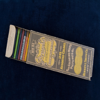

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a historic pack of Crayola Crayons from 1903, created by the Binney & Smith Company in Easton, Pennsylvania. The term "Crayola," coined by Alice Binney, combines the French word for chalk, "craie," with "oleaginous," indicating the crayons' waxy texture. This particular set, intended for "young artists," includes 28 vibrant colors, such as celestial blue and rose pink, and is one of the earliest produced. The box, labeled "No. 51, Young Artists Drawing Crayons, for coloring Maps, Pictures," originally held 28 crayons but now contains 22. The box's artwork illustrates a young girl coloring, reflecting the crayons' role in promoting creativity and education. Crayola crayons have become a sta

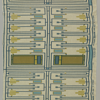

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning textile designed by the influential Frank Lloyd Wright, an American architect known for his innovative designs. Manufactured by F. Schumacher & Co., a prominent textile producer established in New York City in 1889, the piece showcases a geometric pattern composed of rectangular blocks in soothing light blue and olive tones, interconnected by fine lines of darker blue on an off-white background. The dimensions of the textile are 120 cm in height and 57.5 cm in width, with a repeat height of 63.5 cm. Additionally, five alternative colorways are attached to the upper back, showcasing the design's versatility. This textile was generously gifted to the museum by Mr. and Mrs. Burton 

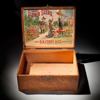

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an antique seed box from the 1890s, showcasing the historical significance of D.M. Ferry & Co. in the seed industry. The box, which was used to display seed packets in general stores, is adorned with a vibrant label that illustrates the company's branding, including the phrase “Choice Flower Seeds.” D.M. Ferry & Co. was instrumental in developing the “commission box,” a display method that revolutionized retail marketing. Acquired by the Smithsonian in 1986, this artifact reflects the advertising strategies of the time. The Smithsonian's vast collection includes over 10,000 seed trade catalogs, which can be explored through the Smithsonian Institution Libraries website.
==> Ground truth an

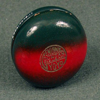

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the intriguing history of the yo-yo, a toy that gained widespread popularity in America thanks to Chicago businessman Donald F. Duncan Sr. The story begins in 1928 when Duncan discovered the yo-yo in San Francisco, where it was being sold by Pedro Flores, a Filipino immigrant who had begun marketing the toy under the name "yo-yo," which translates to "come-come" in his native language. By early 1929, Flores had established his own company and produced over 100,000 wooden yo-yos, understanding the need for live demonstrations to sell his product. Duncan, recognizing the toy's commercial potential, quickly acquired the rights to the yo-yo from Flores and founded Donald F. Duncan Inc. By 1932

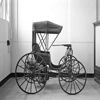

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Duryea Automobile, an iconic vehicle from 1893-94, which is recognized as one of the earliest American-made automobiles. Frank Duryea conducted a historic road test of this vehicle in Springfield, Massachusetts, on September 21, 1893, using a second-hand carriage fitted with a gasoline engine. The following year, he and his brother Charles, along with financial backers, established the Duryea Motor Wagon Company, which became the first American firm to manufacture and sell automobiles. The vehicle is equipped with a one-cylinder, four-cycle, four-horsepower water-cooled gasoline engine, which is positioned nearly horizontally beneath the carriage. It features a gear transmission, a spr

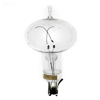

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Edison Light Bulb, an iconic invention from 1879, which is part of the Smithsonian's National Museum of American History collection. Thomas Edison is celebrated as a quintessential American inventor, holding a staggering 1,093 patents. His journey began with a childhood fascination for tinkering, which led him to become a successful businessman. In 1876, he created the first practical telegraph, and just three years later, he unveiled the first practical electric incandescent lamp. The light bulb itself is a carbon-filament encased in a glass bulb filled with inert gas, allowing it to conduct electricity and illuminate. This particular bulb was used during a landmark demonstration at E

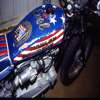

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable Harley-Davidson XR-750, which was famously owned by Evel Knievel, a legendary daredevil known for his thrilling stunts. Knievel, whose real name was Robert Craig Knievel, gained fame in the 1960s for his daring motorcycle jumps, captivating audiences with his breathtaking performances. The XR-750, made from steel, aluminum, and fiberglass, weighs about 300 pounds and was instrumental in many of his most daring jumps, including a record-breaking leap over 14 Greyhound buses in 1975. Knievel's performances not only showcased his extraordinary skills but also celebrated the American love for motor vehicles and live entertainment.
==> Ground truth answer: This exhibit at the Smith

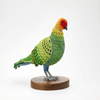

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Laurel Roth Hope's innovative work titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and currently displayed at the Smithsonian American Art Museum. Hope employs humor to address the serious issue of species extinction, crafting crocheted suits that allow common rock pigeons to masquerade as extinct North American birds. Through this playful yet poignant commentary, she encourages viewers to reflect on the concept of biodiversity reclamation and the importance of protecting endangered species. The artwork is made from a variety of materials, including cotton, commercial yarn, and plastic, and measures 18 x 12 x 8 cm. It is part of the exhibition “Connections: Conte

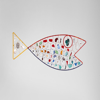

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Fish," a striking sculpture by Alexander Calder, created in 1945 and part of the Hirshhorn Museum and Sculpture Garden's collection in Washington, D.C. Calder, who was born into a family of artists, initially pursued a degree in mechanical engineering before fully committing to his artistic career. After working as a freelance illustrator, he moved to Paris, where he became involved with avant-garde artists and began to create wire sculptures that critics described as “drawings in space.” In 1931, inspired by the simplicity of Piet Mondrian's studio, he invented the “mobile,” a kinetic sculpture that moves with air currents. He also developed “stabiles,” which are static sculptures, and s

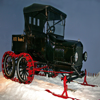

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a 1921 Ford Model T equipped with a snow attachment, illustrating the innovative spirit of rural mail carriers in the early 20th century. As these carriers began to utilize automobiles for their mail routes, they soon discovered that navigating snowy terrain posed significant challenges. In 1906, Virgil White pioneered a solution by converting vehicles into snowmobiles, replacing front tires with skis and outfitting the rear with caterpillar treads. His initial prototype was a Buick Model G, but he soon began producing kits for the popular Ford Model T. By 1922, these kits were sold for $250 to $400 from his company in New Hampshire. The Smithsonian acquired this particular Model T in 1996

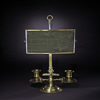

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact from American history: Thomas Jefferson's portable writing desk, which he used to draft the Declaration of Independence in 1776. The desk, designed with a hinged writing board and a locking drawer for writing materials, symbolizes the birth of American democracy. Jefferson, a key figure in the Second Continental Congress, was tasked with articulating the colonies' desire for independence from Britain. The declaration, adopted on July 4, not only outlined the colonies' political aspirations but also served as a foundational document for the United States. The desk accompanied Jefferson throughout his life, witnessing his evolution from a revolutionary leader to the th

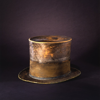

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the top hat of President Abraham Lincoln, a significant artifact housed at the Smithsonian's National Museum of American History. Standing at 6'4”, Lincoln was not only tall but also made a statement with his high top hats. This particular hat was crafted by Washington hat maker J.Y. Davis and includes a black silk mourning band, a tribute to his son Willie, who died in 1862. While the exact date of acquisition is unknown, it is documented that Lincoln last wore this hat on the fateful night of April 14, 1865, before heading to Ford's Theatre. Following his assassination, the War Department preserved the hat along with other personal items, and in 1867, it was transferred to the Smithsonia

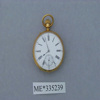

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not one to show off, this exquisite watch served as a testament to his success as a lawyer. The watch's movement, crafted in Liverpool, is renowned for its high-quality standards, and the case was made by an unidentified American manufacturer. A fascinating aspect of this watch is the hidden message engraved by watchmaker Jonathan Dillon during repairs on April 12, 1861, the day of the Confederate attack on Fort Sumter. Dillon's engraving, along with a later inscription by another watchmaker, remains a mystery, but it is clear that the watch was c

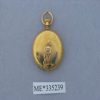

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a captivating pocket watch that once belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not one to show off, this exquisite watch served as a testament to his success as a lawyer. The watch's movement, crafted in Liverpool, is renowned for its high-quality standards, and the case was made by an unidentified American manufacturer. A fascinating aspect of this watch is the hidden message engraved by watchmaker Jonathan Dillon during repairs on April 12, 1861, the day of the Confederate attack on Fort Sumter. Dillon's engraving, along with a later inscription by another watchmaker, remains a mystery, but a late

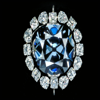

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond, weighing an impressive 45.52 carats, with a captivating dark gray-blue color. The diamond is skillfully cut into a modified antique cushion shape, enhancing its unique characteristics. This exquisite piece of jewelry is set in a platinum mounting, showcasing the diamond's elegance. The diamond's origin is traced back to India, where it was mined. The record for this diamond was last updated on September 26, 2022, and it is part of the Mineral Sciences collection, specifically within the Gems category. The USNM Number for this diamond is NMNH G3551-00, and it is cataloged under the NMNH - Mineral Sciences Department.
==> Ground truth answer: This exhibit features a stunn

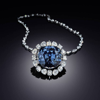

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable diamond necklace by Cartier, Inc., showcasing a single primary gem weighing an impressive 45.52 carats. The diamond is distinguished by its dark gray-blue color and is cut in a modified antique cushion shape. This exquisite piece is part of the Mineral Sciences collection, specifically within the Gems category, and was obtained from India. The record for this diamond was last updated on September 28, 2022, and it is cataloged with the USNM Number NMNH G3551-00 and an IGSN of NHB002JKJ. For further details, you can access the original record [here](http://n2t.net/ark:/65665/3985b643b-fb12-4288-9f1b-2a254447208f).
==> Ground truth answer: This exhibit showcas

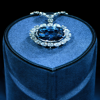

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., showcasing a single primary gem weighing 45.52 carats. The diamond is distinguished by its dark gray-blue color and is cut in a modified antique cushion style. This exquisite piece originates from India and is part of a larger collection that includes 125 diamonds, with a total weight of 188.34 carats. The necklace is crafted from 18K white gold, enhancing its luxurious appearance. This item was last updated on September 26, 2022, and is cataloged under the USNM Number NMNH G3551-00 and an IGSN of NHB002JKJ. It is currently on display at the National Museum of Natural History, specifically i

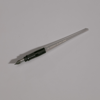

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an Esterbrook pen that holds historical significance as the instrument with which President Lyndon B. Johnson signed the Civil Rights Act of 1964 on July 2, 1964. The pen is part of the Smithsonian's National Museum of African American History and Culture collection, gifted by James F. Dicke, II. The journey to this landmark legislation was complex, having been initially proposed by President John F. Kennedy before his untimely death in November 1963. President Johnson then took on the challenge of advancing the bill through Congress, which involved a record-setting 57-day filibuster in the Senate. The House ultimately passed the bill, and it was signed into law by President Johnson, marki

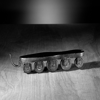

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Volito, an inline skate from 1823, crafted by Robert John Tyers. As the 2014 Winter Olympics approach, it's fascinating to consider how athletes of the past prepared for their sport without modern facilities. The Volito is notable for its unique design, which includes a wooden sole and a single row of five wooden wheels, along with a curved iron bar that serves as a basic brake. Its most innovative feature is the unequal wheel sizes—larger in the center and smaller at the ends—allowing for enhanced maneuverability during turns. This historical artifact is part of the National Museum of American History's collection, although it is currently not on display.
==> Ground truth answer: This

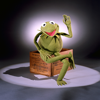

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Kermit the Frog, a character created by Jim Henson that has become a staple of children's television. Kermit first appeared in 1955 on "Sam and Friends" and has since been a prominent figure on "The Muppet Show" and "Sesame Street." Known for his calm demeanor amidst the chaos, Kermit has become a symbol of resilience and the voice of reason. The puppet is made from a combination of materials, including synthetic fibers and felt, and measures 27 inches in height. It is part of the National Museum of American History's collection, thanks to a donation from Jim Henson Productions, and is currently on display in the “Entertainment Nation” exhibition.
==> Ground truth answer: This exhibit show

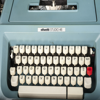

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the typewriter of Octavia Estelle Butler (1947–2006), an iconic science fiction author whose work has left a lasting impact on literature and culture. Butler is best known for her groundbreaking series, including the Patternist series, the Xenogenesis trilogy, and the novels Parable of the Sower and Parable of the Talents, along with the collection Bloodchild and Other Stories. Her writing is characterized by a blend of African American history and speculative fiction, exploring themes of alien life and human identity. By placing characters from the African diaspora in her early novels like Wild Seed and Kindred, she inspired many to envision themselves as heroes in her

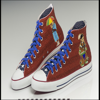

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Kiowa Ah-Day," a striking pair of sneakers created by Kiowa artist Teri Greeves in 2004. The sneakers are made from cotton canvas and commercial rubber, and they incorporate intricate overlay beadwork that showcases Kiowa artistry. With dimensions of 33 x 11 x 15 cm, this piece not only serves as a functional item but also as a cultural artifact, representing the fusion of modern fashion with traditional Native American craftsmanship. The National Museum of the American Indian acquired this piece from Thirteen Moons Gallery in Santa Fe, New Mexico, in 2004, where it is currently part of the museum's collection.
==> Ground truth answer: This exhibit features a remarkable piece titled "Kiow

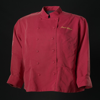

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a compelling collection from the Smithsonian's National Museum of African American History and Culture, generously donated by Dooky Chase's Restaurant and Chef Leah Chase. Known as “The Queen of Creole Cuisine,” Chase is celebrated for her significant role in elevating New Orleans Creole cooking on the global stage. She famously stated, “We changed the world over a bowl of gumbo,” reflecting the restaurant's status as a meeting place for civil rights leaders. Together with her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop, originally opened by her resourceful mother-in-law in the early 1940s, into a fine-dining establishment adorned with white tablec

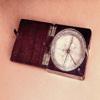

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket compass that dates back to approximately 1804, associated with the Lewis and Clark Expedition. Meriwether Lewis acquired this compass from instrument maker Thomas Whitney in Philadelphia, intending it for the expedition ordered by President Jefferson. The compass is finely crafted with a silver-plated exterior, a mahogany box, a graduated brass rim, and two small brass sight vanes, all protected by a leather carrying case. Its purpose—whether it was intended for Lewis's personal use or as a gift for William Clark—remains a mystery. The Corps of Discovery, led by Lewis and Clark, embarked on their journey in May 1804 to explore uncharted territories and establish diploma

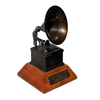

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the prestigious Grammy Award won by Bob Newhart in 1960, celebrating his remarkable career in comedy and television. Newhart, born on September 5, 1929, in Oak Park, Illinois, is renowned for his deadpan delivery and insightful commentary on societal issues. His debut album, The Button-Down Mind of Bob Newhart, was groundbreaking, becoming the first comedy LP to reach No. 1 on the Billboard charts and earning him a Grammy for Album of the Year. He also holds the unique distinction of being the only comedian to win the Grammy for Best New Artist. Newhart's career extended into television, where he starred in iconic sitcoms like The Bob Newhart Show and Newhart, both of which have left a las

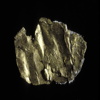

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant gold nugget from 1848, housed at the Smithsonian's National Museum of American History. This nugget is believed to be the first piece of gold discovered at Sutter's Mill in California, an event that sparked the gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall discovered a shiny object in the mill's tailrace. Upon examination, he identified it as a thin scale of pure gold, which he confirmed by biting it. In June of that year, Sutter presented the nugget to Capt. Joseph L. Folsom, who documented it as Specimen No. 1, marking it as the first gold found in Northern California. By August 1848, this nugget was sent to Washington, D.C.,

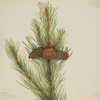

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a watercolor painting by Mary Vaux Walcott, created in 1921, and is part of the Smithsonian American Art Museum's collection. The artwork depicts a lodgepole pine (Pinus Contorta murrayana) and was gifted by the artist in 1970. Walcott's journey into botanical illustration began when a botanist requested her to paint a rare blooming arnica. After marrying Charles Doolittle Walcott, the Secretary of the Smithsonian, in 1914, they spent extensive time in the Canadian Rockies, where she produced numerous watercolor studies of local flora. Her dedication led to the publication of 400 of her illustrations in the five-volume series "North American Wild Flowers," between 1925 and 1929, and she al

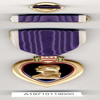

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the esteemed United States Purple Heart, a medal that symbolizes military honor. The medal is crafted in a heart shape, showcasing a gold profile relief of George Washington, set against a rich purple enamel background. Above the bust is a shield that represents Washington's family coat of arms. The reverse side is inscribed with "FOR MILITARY MERIT," honoring those who have displayed exceptional bravery. The medal is suspended from a silk ribbon that is purple with a white edge stripe. It is made from a combination of copper alloy, silk, gold plating, and non-magnetic white metal alloy. The dimensions of this medal are 3.7 cm by 1.1 cm by 8.1 cm (approximately 1 7/16 by 7/16 by 3 3/16 inc

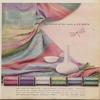

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an advertisement from the Smithsonian's Archives of American Art, dating back to the 1950s, that highlights the work of Dorothy Liebes (1897–1972), an influential American textile designer. Liebes is celebrated for her vibrant color palettes and rich textures, which became hallmarks of mid-20th century American design. Throughout her career, she collaborated with notable architects and fashion designers, including Frank Lloyd Wright and Adrian, creating iconic pieces that defined modern American style. Despite her success, Liebes' significant contributions to design were often overshadowed by her male peers. The advertisement on display is part of the Smithsonian's Archives of American Art

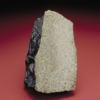

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Nakhla Meteorite Fragment, an extraordinary specimen on display at the Smithsonian's National Museum of Natural History. The Nakhla meteorite is one of only thirty-four meteorites known to have originated from Mars. It fell to Earth on June 28, 1911, in the Nakhla region of Alexandria, Egypt, where it was observed exploding in the atmosphere before breaking into approximately 40 pieces, with a total weight of 22 pounds. Many fragments were found buried up to a meter deep. The Smithsonian acquired two samples shortly after the fall, and in 1962, it added a 480-gram fragment, bringing its total collection to 650 grams by the 1970s. The Nakhlites, as these Martian meteorites are called, a

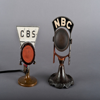

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an RCA Type 50-A microphone, a key artifact from the "Fireside Chats" delivered by President Franklin D. Roosevelt starting on March 12, 1933. These informal radio addresses were pivotal in connecting the president with the American public during the Great Depression, a time of economic turmoil. The microphone, adorned with National Broadcasting Company logos, was preserved by Carleton Smith, who was instrumental in setting up the broadcasts. The first chat took place in the Lincoln Study, while subsequent ones were held in the Diplomatic Reception Room of the White House. Roosevelt's ability to communicate effectively with the public through this new medium was a transformative force in A

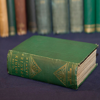

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "On the Origin of Species," authored by Charles Darwin in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the anniversary of the HMS Beagle's launch on May 11, 1820, a ship that played a crucial role in Darwin's scientific exploration. The Beagle was launched from Woolwich Dockyard in London and underwent several modifications before embarking on its second survey voyage on December 27, 1831, with Darwin on board as a young naturalist. Over the course of five years, this expedition to South America and the Galápagos Islands allowed Darwin to gather extensive data on geological formations, fossils, and plant specimens, which he used to develop his revo

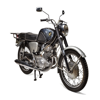

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Robert M. Pirsig's 1966 Honda Super Hawk motorcycle, a key artifact from his influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." Published in 1974, the book sold a million copies in its first year and initiated a global movement that encouraged individuals to reevaluate their relationships with technology and seek a more balanced life. The narrative is inspired by Pirsig's memorable 1968 road trip with his son Chris, during which they traveled 5,700 miles from Minnesota to San Francisco, deepening their bond and understanding of the world around them. Pirsig's insights into the human-technology dynamic have made him a prominent figure in the field of huma

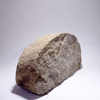

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Plymouth Rock Piece from 1620, an iconic artifact at the National Museum of American History. Traditionally recognized as the landing site of the Mayflower Pilgrims, Plymouth Rock is steeped in history. In 1774, the townspeople moved the rock from its original location to the town square, where it split into two halves. The lower half remained in its original spot, while the upper half was relocated to the meeting house. It wasn't until 1880 that both halves were reunited, although several pieces had been removed over the years. In the 1920s, the Plymouth Antiquarian Society discovered a 400-pound fragment being used as a doorstep at a historic site. They broke it into three parts, and

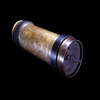

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Pneumatic Mail Container from 1953, showcasing the remarkable pneumatic tube systems that were installed beneath city streets to facilitate mail delivery. Each canister, or carrier, could hold up to 500 letters and was propelled through the tubes by compressed air, reaching an average speed of 35 miles per hour. At its peak, the system managed to transport an impressive six million pieces of mail daily, with five carriers dispatched every minute. The first pneumatic tube system was introduced in Philadelphia in 1893, followed by New York City in 1897, and later expanded to other major cities like Boston, Chicago, and St. Louis. By 1915, over 56 miles of pneumatic tubes had been install

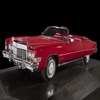

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning 1973 red convertible Eldorado Cadillac, a highlight of the Smithsonian's National Museum of African American History and Culture collection. The Cadillac is a symbol of luxury and craftsmanship, with its elegant design and high-quality materials, including a leather interior and a powerful 500-horsepower V8 engine. This particular Cadillac was owned by the legendary Chuck Berry, a pioneering rock 'n' roll artist known for his lively performances and heartfelt lyrics about his experiences as a Black man in America. Berry's love for cars is evident in his song “Rock 'n' Roll Music,” which references his 1969 red Eldorado Cadillac. The car was gifted to the Smithsonian by Berry him

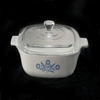

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a classic white casserole dish from CorningWare, dating back to 1965, adorned with the brand's distinctive blue cornflower design. This dish is a testament to the evolution of kitchenware, as it was initially created from Pyroceram, a glass-ceramic material developed for military use during World War II. Its unique properties allowed it to withstand rapid temperature shifts while resisting stains and odors, making it a versatile choice for cooking, freezing, and serving. In the 1990s, CorningWare shifted towards ceramic stoneware to meet consumer demand for more colorful and varied designs, but the original glass-ceramic line made a comeback in 2009 due to its enduring 

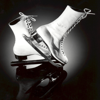

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the autographed ice skates of Sonja Henie, a legendary Norwegian figure skater from around 1945. Henie is celebrated for revolutionizing women's figure skating in the late 1920s and 1930s by introducing the fashionable white leather skates, a stark contrast to the traditional black. She won her first world title in 1927 and went on to dominate the sport, securing 10 consecutive titles. Henie's performances were not only technically impressive but also artistic, as she incorporated dance into her routines. She triumphed at the Olympics, winning gold in ladies singles at the 1928, 1932, and 1936 Winter Games. After her success in skating, she transitioned to film, starring in the 1936 movie 

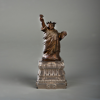

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable artifact: a miniature replica of the Statue of Liberty, commonly known as the American Committee Model. Produced in the United States to support the construction of the statue's pedestal in New York Harbor, these statuettes were created in significant numbers, with an estimated 100,000 produced. The design, crafted by French sculptor Frédéric-Auguste Bartholdi, was available in both six-inch and twelve-inch sizes. A national newspaper campaign effectively marketed these models, selling the six-inch version for one dollar and the twelve-inch version for five dollars. Richard Butler, a rubber manufacturer from New York, was instrumental in leading the American Committee that ove

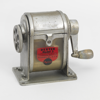

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Dexter Model 3 Pencil Sharpener, dating back to approximately 1920, produced by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. Constructed from metal, cellulose, and painted wood, it measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.). Gifted by Lucy Commoner, this sharpener evokes fond memories of school for many. The Dexter design evolved from the original model introduced in 1914, which featured a rotating wheel with calibrated openings for various pencil sizes. By the 1920s, APSCO had expanded its product line to include several models, each with unique styles and price points. Its affordability, priced at just $1, combined with its efficient design, 

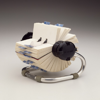

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Rolodex Open Rotary Card File, an emblematic office supply that has stood the test of time. Manufactured by the Rolodex Corporation in the USA, this item is constructed from a combination of materials including bent tubular metal, molded plastic, rubber, and paper, with dimensions of 18 x 18 x 16.5 cm (7 1/16 x 7 1/16 x 6 1/2 in.). The Rolodex operates on a cylindrical mechanism that allows users to rotate through A-Z index cards for efficient contact management. Despite the rise of digital alternatives, the Rolodex remains a popular choice in workplaces, symbolizing a nostalgic yet enduring approach to organization. The invention is credited to Arnold Neustadter, a

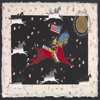

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the "Lakota Horse Mask," an artwork by Jim Yellowhawk, a Cheyenne River Lakota artist, created in 2008 using acrylic on paper and gold leaf. The piece is part of the Smithsonian's National Museum of the American Indian collection, gifted by the artist. It highlights the deep connection between American Indians and horses, often referred to as the Horse Nation, and their shared history. Horses have been pivotal in Native cultures, serving as both companions in peaceful times and formidable partners in warfare. This artwork is particularly significant as it represents the Cheyenne River Lakota tribe, which is one of the seven tribes comprising the Sioux nation. The mask is displayed in the o

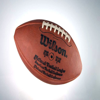

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wilson Duke football, a significant artifact from Super Bowl XIV, which took place on January 20, 1980, at the Rose Bowl in Pasadena, California. The Wilson Sporting Goods Company introduced this football in the early 1940s, known for its premium leather and construction, including sewn ends and lock-stitch seams. Since Super Bowl II in 1968, it has been the official ball of the NFL championship game. The featured football was pivotal in the match where the Pittsburgh Steelers defeated the Los Angeles Rams with a score of 31-19, marking the Steelers' fourth Super Bowl victory. Quarterback Terry Bradshaw also earned the Most Valuable Player award for the second consecutive year. Althoug

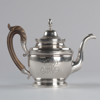

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning silver teapot crafted by Peter Bentzon, an American artisan known for his work from around 1783 until after 1850. The teapot is elegantly designed with a gracefully curved spout, a wooden leaf motif, and a gracefully curved spout, all set upon a broad pedestal foot. Its hinged domed cover is topped with an acorn finial, adding a unique touch to its ornamentation. The piece is engraved with the monogram "MC" and the name "Rebecca Dawson" on its base, providing insight into its historical context. This exquisite object is part of the National Museum of African American History and Culture's collection, where it serves to illuminate themes of slavery, freedom, and African American 

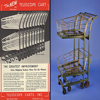

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Telescoping Shopping Cart, an invention that revolutionized shopping convenience, created by Orla E. Watson in 1946. The cart, which made its debut in 1947 at Floyd's Super Market in Kansas City, Missouri, introduced a practical solution for shoppers by allowing multiple carts to nest together, thereby requiring only one-fifth of the space of a traditional cart when parked. This exhibit is part of the National Museum of American History's collection, generously donated by Floyd's Super Market, and is showcased in the exhibit “Food: Transforming the American Table.” For additional insights into the evolution of food shopping and culinary innovations, visitors can explore the “FOOD: Tran

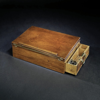

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Thomas Jefferson's portable writing desk, an essential tool used during the drafting of the Declaration of Independence in 1776. Jefferson, a delegate from Virginia, was tasked with articulating the colonies' desire for independence from Britain, and he chose to work on this declaration in the cool confines of the Senate chamber. The desk, designed by Jefferson himself, includes a hinged writing board and a locking drawer for storing writing essentials. As a member of the Continental Congress, he sought to encapsulate the aspirations of the American people in this declaration, which was adopted on July 4, 1776. The desk accompanied Jefferson throughout his life, witnessing his evolution fr

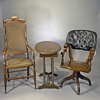

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an important artifact from American history: the chair used by General Ulysses S. Grant during the surrender of the Confederate Army of Northern Virginia at Appomattox Court House on April 9, 1865. This meeting was pivotal in the conclusion of the Civil War, as Grant and General Robert E. Lee discussed the terms of surrender before signing them at the oval table. The chair, made of wood and measuring 37 1/2 inches in height, is part of the collection at the Smithsonian Institution, gifted by Lee's granddaughter, and is displayed in the "Price of Freedom" exhibition at the National Museum of American History.
==> Ground truth answer: This exhibit focuses on a pivotal moment in American hist

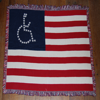

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a hand-stitched lap blanket that incorporates the universal access symbol, crafted by disability rights advocates from ADAPT, an organization founded in 1983. The blanket, made from cotton and measuring 129 cm by 95 cm, serves as a powerful symbol of the fight for civil rights among disabled individuals. ADAPT, which stands for American Disabled for Attendant Programs Today, was established in Denver after the formation of communities among disabled individuals post-World War II. This piece not only represents the struggle for disability rights but also the broader movement for social justice. Although it is currently not on display, it is part of the National Museum of American History's 

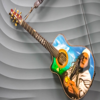

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the guitar of Carlos Vives, a Grammy Award-winning Colombian singer and Grammy Award-winning composer known for his vallenato music. Vallenato, a lively genre from Colombia's Atlantic coast, blends European instruments like the accordion with poetic storytelling and traditional rhythms from the Arhuaco indigenous people. Historically, this music was performed by rural workers and cowboys, remaining largely local until the 1990s when Vives and other artists popularized it by merging it with pop and rock, thus reaching a global audience. The guitar on display, handmade by a Colombian luthier, features an airbrushed portrait of an Arhuaco and was last played by Vives during a concert at the H

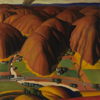

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a striking painting by Ross Dickinson, an artist whose work captures the essence of California's Central Valley during the Great Depression. Created for the Public Works of Art Project, the piece illustrates the lush landscape of farms juxtaposed against the harsh realities of dry, rocky hills. The image conveys a sense of hope for those fleeing the Dust Bowl, yet it also hints at the challenges they may face. A small fire in the foreground and a larger plume of smoke in the distance serve as reminders of the ever-present threat of wildfires during California's dry seasons. Dickinson's work not only reflects the beauty of the landscape but also encapsulates the complex social and economic 

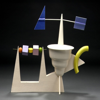

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the innovative work of Peter Shire, an artist born in Los Angeles in 1947. It includes a striking teapot that showcases Shire's unique approach to ceramic art, blending vibrant colors and unconventional shapes. The teapot is composed of three-dimensional forms, including squares and balls, alongside whimsical squiggly rods and hollow tubes. Shire's goal was to challenge and democratize the concept of "tea-time," making it a more inclusive and accessible experience. After 1985, he shifted his focus from teapot design to furniture, producing a significant body of work. The piece is part of the Smithsonian American Art Museum's collection, gifted by Donna and John Donaldson in honor of the Ja

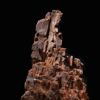

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Spotsylvania tree stump, an artifact from the Civil War, currently displayed at the Smithsonian's National Museum of American History. The stump, which dates back to 1864–65, was once part of a large oak tree located in a serene meadow near Spotsylvania Court House, Virginia. On May 12, 1864, this tranquil setting became the scene of intense combat between Confederate forces and Union troops, leading to the area being referred to as the Bloody Angle. The tree was caught in the crossfire, with several Minié balls still embedded in its wood, serving as a stark reminder of the violence that unfolded during the Battle of Spotsylvania Court House. The battle, which lasted from May 8 to May 

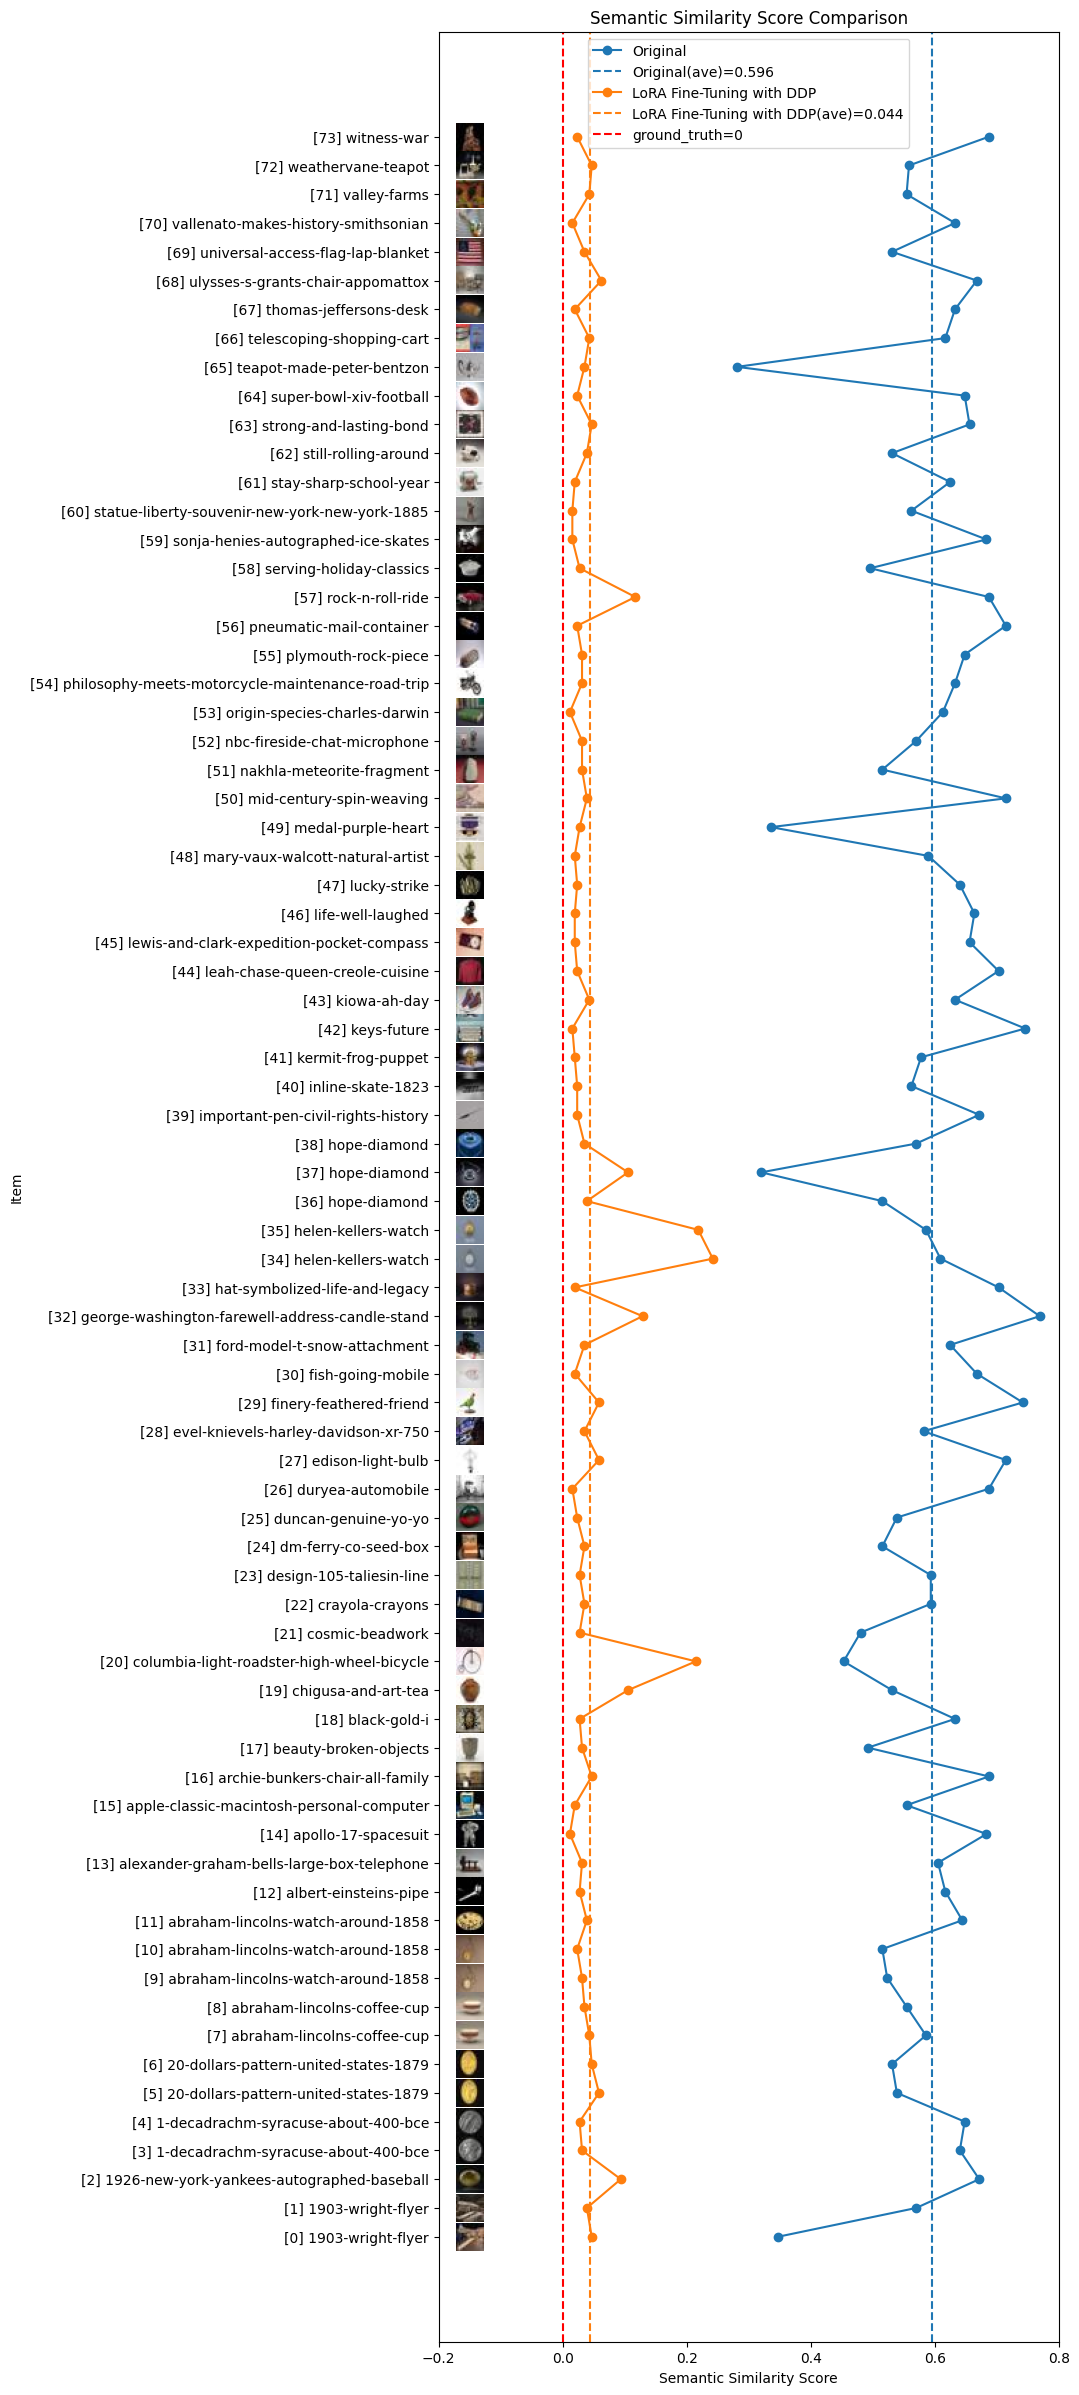

In [2]:
# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

# Perform batch inference on the test set and save results to a CSV file
my_utils.batch_inference_model(lora_model, processor, dataset['test'], './results/inference_results/inference_results_after_finetuning.csv', 14)

# Plot similarity scores (original vs. fine-tuned) from the inference CSV files, using thumbnails, and save the plot image locally
my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv'),
                                 ('LoRA Fine-Tuning with DDP', './results/inference_results/inference_results_after_finetuning.csv')],
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_scores_after_finetuning.jpg')


## 3.4 Save the Fine-Tuned Model Locally  

In [3]:
# Merge base model with LoRA adapter
print(f'==> Creating fine-tuned model by merging base model weights with LoRA adapter weights...')
merged_model = lora_model.merge_and_unload()

# Save processor
print(f'==> Saving processor...')
my_utils.print_processor_info_to_file(processor, './results/model_info/updated_processor_info.txt')
processor.save_pretrained(save_directory='./results/finetuned_model')

# Save fine-tuned model
print(f'==> Saving fine-tuned model...')
my_utils.print_model_info_to_file(merged_model, './results/model_info/finetuned_model_info.txt')
my_utils.print_model_parameters_to_file(merged_model, './results/model_info/finetuned_model_parameters.txt')
merged_model.save_pretrained(save_directory='./results/finetuned_model')


==> Creating fine-tuned model by merging base model weights with LoRA adapter weights...
==> Saving processor...
==> Printing processor info...
==> Regular token count: 32000, regular+special token count: 32004, bos_token: <s>, eos_token: </s>, pad_token: <pad>
==> For complete processor info, refer to ./results/model_info/updated_processor_info.txt.
==> Saving fine-tuned model...
==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/finetuned_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, False)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, False)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, False)
model.vision_model.e